In [56]:
#!/usr/bin/env python3
"""
NS-3–like IoT network simulator in pure Python with an energy model.

Features
- Discrete-event simulation (priority-queue scheduler)
- Devices (nodes) that generate variable-size packets to a single gateway
- Simple link model (bandwidth, delay, jitter, loss, buffer)
- Radio MAC states (SLEEP/IDLE/RX/TX) with per-state power draw
- Energy model (mAh capacity, voltage, Joule accounting)
- Simulated RAM behaviour (baseline + per-packet alloc + periodic GC)
- Uplink/downlink throughput stats; per-device metrics; CSV logging

No external dependencies required (standard library only).

How to run
    python ns3_like_iot_sim_with_energy_model.py

Adjust the CONFIG section at the bottom to tune the scenario.
"""
from __future__ import annotations

import heapq
import math
import random
import csv
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Callable, List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque



In [57]:
# ==========================
# Discrete Event Scheduler
# ==========================
class Scheduler:
    def __init__(self):
        self._q: List[Tuple[float, int, Callable[[], None]]] = []
        self.t: float = 0.0
        self._counter = 0

    def at(self, t: float, fn: Callable[[], None]):
        self._counter += 1
        heapq.heappush(self._q, (t, self._counter, fn))

    def after(self, dt: float, fn: Callable[[], None]):
        self.at(self.t + max(0.0, dt), fn)

    def run_until(self, t_end: float):
        while self._q and self.t <= t_end:
            t, _, fn = heapq.heappop(self._q)
            if t > t_end:
                # Put it back; we're done
                heapq.heappush(self._q, (t, _, fn))
                break
            self.t = t
            fn()

In [58]:
# ==========================
# Energy & Radio models
# ==========================
class RadioState(Enum):
    SLEEP = auto()
    IDLE = auto()
    RX = auto()
    TX = auto()

@dataclass
class Battery:
    capacity_mAh: float
    voltage_V: float = 3.7
    remaining_mAh: float = None

    def __post_init__(self):
        if self.remaining_mAh is None:
            self.remaining_mAh = self.capacity_mAh
        self.energy_used_J: float = 0.0

    @property
    def percent(self) -> float:
        return max(0.0, 100.0 * self.remaining_mAh / self.capacity_mAh)

    def draw(self, power_mW: float, duration_s: float):
        """Draw power (mW) for duration (s); reduce remaining capacity.
        mWh = (mW * s) / 3600, mAh = mWh / V
        """
        if duration_s <= 0:
            return
        mWh = (power_mW * duration_s) / 3600.0
        mAh = mWh / max(1e-9, self.voltage_V)
        self.remaining_mAh = max(0.0, self.remaining_mAh - mAh)
        self.energy_used_J += (power_mW / 1000.0) * duration_s

@dataclass
class RadioPowerProfile:
    # Typical low-power radio numbers (adjust per your hardware)
    sleep_mW: float = 0.02
    idle_mW: float = 1.2
    rx_mW: float = 30.0
    tx_mW: float = 45.0
    # Additional RF energy per transmitted bit (power amplifier cost proxy)
    tx_extra_mW_per_kbps: float = 2.0  # scales with data rate used during TX



In [59]:
# ==========================
# Network primitives
# ==========================
@dataclass
class Packet:
    size_bytes: int
    src: str
    dst: str
    created_at: float
    id: int = field(default_factory=lambda: random.randrange(1_000_000_000))

@dataclass
class Link:
    name: str
    scheduler: Scheduler
    bandwidth_bps: float
    delay_s: float
    jitter_s: float = 0.0
    loss: float = 0.0  # 0..1
    buffer_bytes: int = 64_000

    # Runtime
    _queue_bytes: int = 0
    _busy_until: float = 0.0
    delivered_bytes: float = 0.0
    _last_util_time: float = 0.0

    def send(self, pkt: Packet, on_deliver: Callable[[Packet], None], on_drop: Callable[[Packet, str], None]):
        # Drop for random loss
        if random.random() < self.loss:
            on_drop(pkt, f"random_loss@{self.name}")
            return
        # Check buffer
        if self._queue_bytes + pkt.size_bytes > self.buffer_bytes:
            on_drop(pkt, f"buffer_overflow@{self.name}")
            return
        self._queue_bytes += pkt.size_bytes

        # Compute serialization delay; respect link busy time
        start_time = max(self.scheduler.t, self._busy_until)
        ser = pkt.size_bytes * 8 / self.bandwidth_bps
        tx_end = start_time + ser
        self._busy_until = tx_end

        # Update utilization bookkeeping
        if self._last_util_time < tx_end:
            self._last_util_time = tx_end

        # Schedule delivery after propagation + jitter
        prop = self.delay_s + (random.uniform(-self.jitter_s, self.jitter_s) if self.jitter_s > 0 else 0)
        arrival = tx_end + max(0.0, prop)

        def deliver():
            self._queue_bytes -= pkt.size_bytes
            # Possible late loss simulation could go here
            self.delivered_bytes += pkt.size_bytes
            on_deliver(pkt)

        self.scheduler.at(arrival, deliver)



In [60]:
# ==========================
# Nodes
# ==========================
@dataclass
class Device:
    name: str
    scheduler: Scheduler
    link_to_gateway: Link
    battery: Battery
    power: RadioPowerProfile
    app_interval_s: Tuple[float, float] = (1.0, 5.0) # traffic: uniform(min,max)
    payload_bytes: Tuple[int, int] = (50, 300)
    mem_baseline_mb: float = 2.0
    mem_per_packet_mb: float = 0.01
    mem_gc_period_s: float = 30.0
    mem_gc_release_frac: float = 0.5

    # runtime
    radio_state: RadioState = RadioState.SLEEP
    _last_state_change_t: float = 0.0
    mem_used_mb: float = 0.0
    packets_tx: int = 0
    bytes_tx: int = 0
    bytes_rx: int = 0

    def start(self):
        self.mem_used_mb = self.mem_baseline_mb
        self._schedule_next_app_event(initial=True)
        self._schedule_gc()

    def _schedule_gc(self):
        self.scheduler.after(self.mem_gc_period_s, self._gc)

    def _gc(self):
        # simulate partial reclaim
        freed = (self.mem_used_mb - self.mem_baseline_mb) * self.mem_gc_release_frac
        self.mem_used_mb = max(self.mem_baseline_mb, self.mem_used_mb - freed)
        self._schedule_gc()

    def _schedule_next_app_event(self, initial=False):
        dt = 0.0 if initial else random.uniform(*self.app_interval_s)
        self.scheduler.after(dt, self._app_send)

    def _set_radio(self, state: RadioState):
        now = self.scheduler.t
        dt = now - self._last_state_change_t
        # Account power for time spent in previous state
        if dt > 0:
            p = {
                RadioState.SLEEP: self.power.sleep_mW,
                RadioState.IDLE: self.power.idle_mW,
                RadioState.RX: self.power.rx_mW,
                RadioState.TX: self.power.tx_mW,
            }[self.radio_state]
            self.battery.draw(p, dt)
        self.radio_state = state
        self._last_state_change_t = now

    def _finish_tx_idle(self):
        # move back to idle after tx accounting stationary power during TX already applied
        self._set_radio(RadioState.IDLE)

    def _app_send(self):
        if self.battery.remaining_mAh <= 0:
            return  # dead
        size = random.randint(*self.payload_bytes)
        pkt = Packet(size_bytes=size, src=self.name, dst="gateway", created_at=self.scheduler.t)

        # TX: account radio draw during serialization + extra cost proportional to rate
        rate_kbps = self.link_to_gateway.bandwidth_bps / 1000.0
        ser = size * 8 / self.link_to_gateway.bandwidth_bps
        self._set_radio(RadioState.TX)
        # Account extra RF cost during TX window
        self.battery.draw(self.power.tx_extra_mW_per_kbps * rate_kbps, ser)
        # Schedule return to IDLE at end of TX
        self.scheduler.after(ser, self._finish_tx_idle)

        # Memory alloc
        self.mem_used_mb += self.mem_per_packet_mb

        def on_deliver(p: Packet):
            # nothing for device on uplink arrival
            pass

        def on_drop(p: Packet, reason: str):
            # spent energy regardless; nothing else to do
            pass

        self.link_to_gateway.send(pkt, on_deliver, on_drop)
        self.packets_tx += 1
        self.bytes_tx += size

        # schedule next app send
        self._schedule_next_app_event()

@dataclass
class Gateway:
    name: str
    scheduler: Scheduler
    link_from_devices: Link  # shared medium from devices (simple model)

    packets_rx: int = 0
    bytes_rx: int = 0

    def receive(self, pkt: Packet):
        self.packets_rx += 1
        self.bytes_rx += pkt.size_bytes



In [85]:
# ==========================
# Orchestration & Stats
# ==========================
@dataclass
class Simulation:
    duration_s: float
    n_devices: int
    seed: int = 42

    # Link & device parameters
    bandwidth_kbps: float = 250.0
    delay_ms: float = 50.0
    jitter_ms: float = 5.0
    loss: float = 0.01
    buffer_bytes: int = 128_000

    battery_mAh: float = random.uniform(100, 300) # Randomize battery capacity between 100 and 300 mAh
    voltage_V: float = 3.0

    def run(self) -> Dict:
        random.seed(self.seed)
        sched = Scheduler()

        link = Link(
            name="uplink",
            scheduler=sched,
            bandwidth_bps=self.bandwidth_kbps * 1000.0,
            delay_s=self.delay_ms / 1000.0,
            jitter_s=self.jitter_ms / 1000.0,
            loss=self.loss,
            buffer_bytes=self.buffer_bytes,
        )

        power = RadioPowerProfile()
        gateway = Gateway(name="gateway", scheduler=sched, link_from_devices=link)

        devices: List[Device] = []
        for i in range(self.n_devices):
            initial_batt = random.uniform(0.3 * self.battery_mAh, self.battery_mAh)
            mem_baseline = random.uniform(0.06, 0.5)
            dev = Device(
                name=f"dev{i:02d}",
                scheduler=sched,
                link_to_gateway=link,
                battery=Battery(capacity_mAh=self.battery_mAh, voltage_V=self.voltage_V, remaining_mAh=initial_batt),
                power=power,
                app_interval_s=(0.5, 3.0),
                payload_bytes=(100*1024, 1024*1024),  # 100 KB to 200KB payloads
                mem_baseline_mb=mem_baseline,
                mem_per_packet_mb=0.005,
                mem_gc_period_s=20.0 + 5.0 * random.random(),
                mem_gc_release_frac=0.6,
            )
            devices.append(dev)
            dev.start()

        # Bandwidth variation:
        def vary_bandwidth():
            # Example: bandwidth varies sinusoidally around base bandwidth ± 30%
            base_bps = self.bandwidth_kbps * 1000
            t = sched.t
            # freq = 1 cycle per 60 seconds
            variation = 0.3 * base_bps * math.sin(2 * math.pi * t / 60)
            new_bw = base_bps + variation
            link.bandwidth_bps = max(1_000, new_bw)  # minimum 1 kbps
            sched.after(1.0, vary_bandwidth)  # update every second

        sched.after(1.0, vary_bandwidth)

        # Wire link delivery to gateway
        def make_on_deliver():
            def on_deliver(pkt: Packet):
                gateway.receive(pkt)
            return on_deliver

        link_on_deliver = make_on_deliver()

        # Replace link's send to keep gateway hook
        original_send = link.send
        def send_with_gateway(pkt: Packet, on_deliver, on_drop):
            original_send(pkt, lambda p: (link_on_deliver(p), on_deliver(p) if on_deliver else None), on_drop)
        link.send = send_with_gateway  # type: ignore

        # Logging
        log_rows: List[List] = []
        log_header = [
            "t",
            "packets_rx",
            "bytes_rx",
            "link_delivered_bytes",
        ] + [
            f"{d.name}_batt_pct" for d in devices
        ] + [
            f"{d.name}_mem_mb" for d in devices
        ] + [
            f"{d.name}_bytes_tx" for d in devices
        ]

        def sample():
            row = [
                sched.t,
                gateway.packets_rx,
                gateway.bytes_rx,
                link.delivered_bytes,
            ] + [
                round(d.battery.percent, 3) for d in devices
            ] + [
                round(d.mem_used_mb, 3) for d in devices
            ] + [
                d.bytes_tx for d in devices
            ]
            log_rows.append(row)
            # schedule next sample
            sched.after(1.0, sample)

        sched.after(0.0, sample)

        # Run
        sched.run_until(self.duration_s)

        # # Initialize dashboard storage
        # history_len = 60  # number of samples to keep in view
        # time_data = deque(maxlen=history_len)
        # battery_data = {d.name: deque(maxlen=history_len) for d in devices}
        # mem_data = {d.name: deque(maxlen=history_len) for d in devices}

        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        # # Update loop for dashboard
        # def update_dashboard(frame):
        #     t = frame
        #     time_data.append(t)
        #     for d in devices:
        #         battery_data[d.name].append(d.battery.percent)
        #         mem_data[d.name].append(d.mem_used_mb)
        #     ax1.clear()
        #     for name, hist in battery_data.items():
        #         ax1.plot(time_data, hist, label=f"{name} batt")
        #     ax1.set_ylabel("Battery %")
        #     ax1.legend(loc='upper right')

        #     ax2.clear()
        #     for name, hist in mem_data.items():
        #         ax2.plot(time_data, hist, label=f"{name} mem")
        #     ax2.set_ylabel("Memory (MB)")
        #     ax2.legend(loc='upper right')

        # # Keep the animation object in a variable so it isn't garbage-collected
        # anim = animation.FuncAnimation(
        #     fig,
        #     update_dashboard,
        #     interval=500,
        #     cache_frame_data=False  # suppresses cache warning
        # )
        # anim.save('sim_animation.mp4', writer='ffmpeg', fps=2, dpi=100)
        # plt.tight_layout()
        # # Show the dashboard
        # plt.show(block=True)
        
        # Save CSV
        csv_path = "sim_metrics.csv"
        with open(csv_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(log_header)
            writer.writerows(log_rows)

        # Summary
        summary = {
            "duration_s": self.duration_s,
            "packets_rx": gateway.packets_rx,
            "bytes_rx": gateway.bytes_rx,
            "avg_batt_pct": sum(d.battery.percent for d in devices) / len(devices),
            "min_batt_pct": min(d.battery.percent for d in devices),
            "max_batt_pct": max(d.battery.percent for d in devices),
            "csv": csv_path,
        }
        return summary


In [86]:
# ==========================
# Entry point with defaults
# ==========================
sim = Simulation(
    duration_s=1200.0,   # simulate 2 minutes
    n_devices=4,
    seed=7,
    bandwidth_kbps=150.0,
    delay_ms=40.0,
    jitter_ms=5.0,
    loss=0.02,
    buffer_bytes=128_000,
    battery_mAh=240.0,
    voltage_V=3.0,
)
summary = sim.run()
print("=== Simulation Summary ===")
for k, v in summary.items():
    print(f"{k}: {v}")
print("Metrics CSV written to:", summary["csv"])


=== Simulation Summary ===
duration_s: 1200.0
packets_rx: 10
bytes_rx: 1109723
avg_batt_pct: 0.0
min_batt_pct: 0.0
max_batt_pct: 0.0
csv: sim_metrics.csv
Metrics CSV written to: sim_metrics.csv


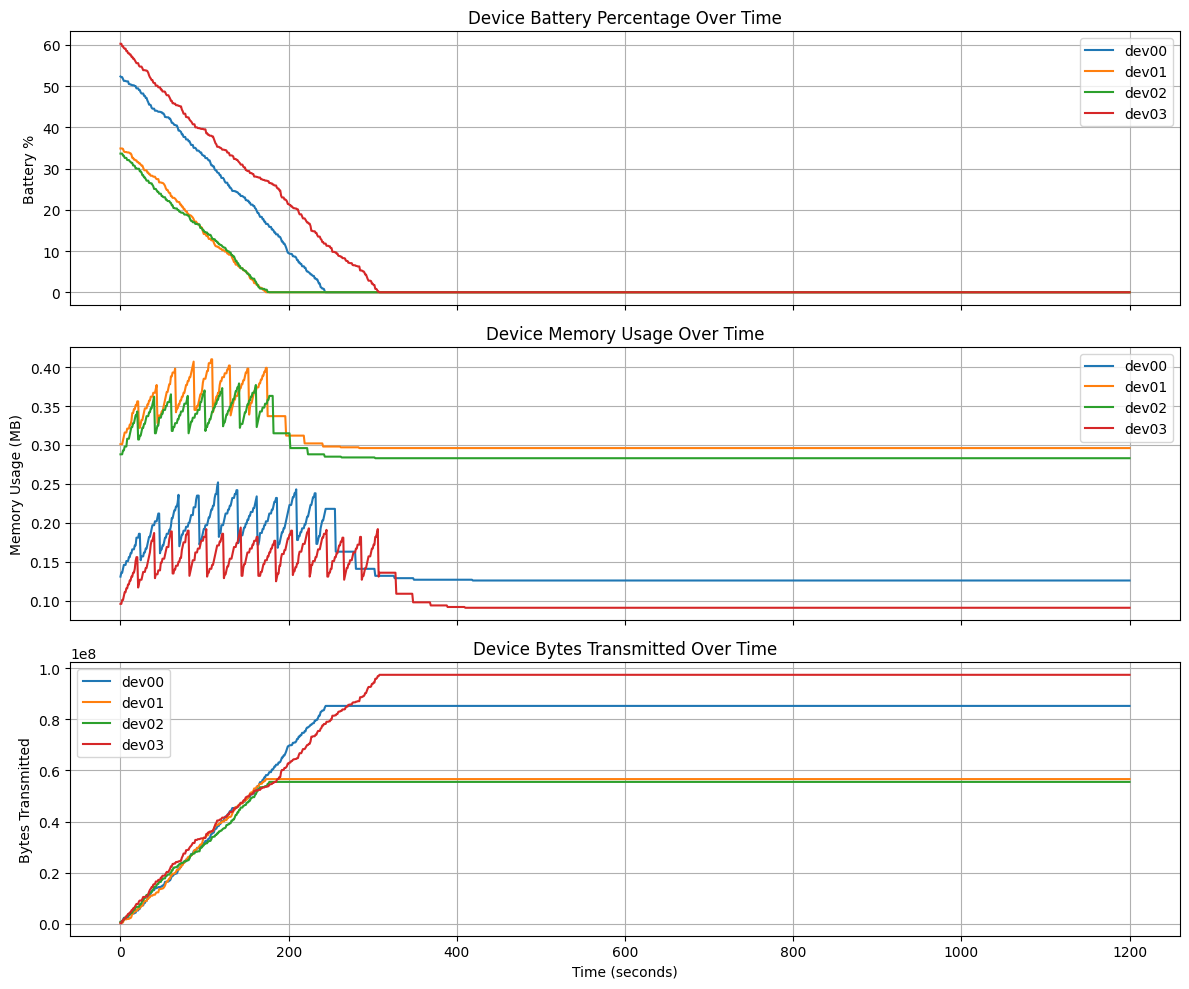

In [87]:
csv_path = summary["csv"]

# Load CSV data
with open(csv_path, newline='') as f:
    reader = csv.reader(f)
    header = next(reader)
    rows = list(reader)

# Extract time column
times = [float(row[0]) for row in rows]

# Identify device names by parsing header (battery, mem, bytes_tx)
devices = []
batt_indices = []
mem_indices = []
tx_indices = []

for i, colname in enumerate(header):
    if colname.endswith("_batt_pct"):
        devices.append(colname[:-9])  # strip "_batt_pct"
        batt_indices.append(i)
    elif colname.endswith("_mem_mb"):
        mem_indices.append(i)
    elif colname.endswith("_bytes_tx"):
        tx_indices.append(i)

# Prepare data arrays per device
batt_data = [[float(row[idx]) for row in rows] for idx in batt_indices]
mem_data = [[float(row[idx]) for row in rows] for idx in mem_indices]
tx_data = [[int(row[idx]) for row in rows] for idx in tx_indices]

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Battery %
for i, dev in enumerate(devices):
    axs[0].plot(times, batt_data[i], label=dev)
axs[0].set_ylabel("Battery %")
axs[0].set_title("Device Battery Percentage Over Time")
axs[0].legend()
axs[0].grid(True)

# Memory MB
for i, dev in enumerate(devices):
    axs[1].plot(times, mem_data[i], label=dev)
axs[1].set_ylabel("Memory Usage (MB)")
axs[1].set_title("Device Memory Usage Over Time")
axs[1].legend()
axs[1].grid(True)

# Bytes Transmitted (cumulative)
for i, dev in enumerate(devices):
    axs[2].plot(times, tx_data[i], label=dev)
axs[2].set_ylabel("Bytes Transmitted")
axs[2].set_title("Device Bytes Transmitted Over Time")
axs[2].set_xlabel("Time (seconds)")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()